# Get Data

Note: data is the three scale channel features

In [1]:
import h5py
import gc
import numpy as np

# load_path='F:/wangqi/nistdataset/AAPlantD1_2GHz_TX1_hpol_run4_pp.mat'  # 3600:39600 120
# load_mat=h5py.File(load_path,'r')
# IQdata=load_mat['IQdata'][3600:39600,0:256].view('complex')
# locations=120
# records=300

# load_path='F:/wangqi/nistdataset/AAPlantD1_2GHz_TX1_vpol_run3_pp.mat'   # 6600:42600  120
# load_mat=h5py.File(load_path,'r')
# IQdata=load_mat['IQdata'][6600:42600,0:256].view('complex')
# locations=120
# records=300

# load_path='F:/wangqi/nistdataset/AAPlantD3_2GHz_TX2b_vpol_run32_pp.mat'  # 3900:39900 120
# load_mat=h5py.File(load_path,'r')
# IQdata=load_mat['IQdata'][3900:39900,0:256].view('complex')
# locations=120
# records=300

# load_path='F:/wangqi/nistdataset/AAPlantD3_2GHz_TX2b_hpol_run34_pp.mat'  # 3900:39900 120
# load_mat=h5py.File(load_path,'r')
# IQdata=load_mat['IQdata'][2100:33900,0:256].view('complex')
# locations=106
# records=300

# load_path='F:/wangqi/nistdataset/AAPlantD2_2GHz_TX1_hpol_internal_runE_pp.mat'  # 1500:31200 99
# load_mat=h5py.File(load_path,'r')
# IQdata=load_mat['IQdata'][1500:31200,0:256].view('complex')
# locations=99
# records=300
# # IQdata=load_mat['IQdata'][25500:26700,0:256].view('complex')
# # locations=4

# load_path='F:/wangqi/nistdataset/AAPlantD3_2GHz_TX2b_vpol_internal_run33_pp.mat' # 14700:42900 94
# load_mat=h5py.File(load_path,'r')
# IQdata=load_mat['IQdata'][14700:42900,0:256].view('complex')
# locations=94
# records=300
# # IQdata=load_mat['IQdata'][28800:30000,0:256].view('complex')
# # locations=4

load_path='F:/wangqi/nistdataset/GBurgD2_2GHz_TX1_longPol_run2_pp.mat'
load_mat=h5py.File(load_path,'r')
IQdata=load_mat['IQdata'][500:9800,0:256].view('complex')
locations=186
records=50

# Hyper-parameters

In [2]:
# training parameters
seed = 0                        # random seed
batch_size = 32                # batch size
num_epoch = 50                   # the number of training epoch
patience = 5                  # If no improvement in 'patience' epochs, early stop
learning_rate = 0.0004          # learning rate
weight_decay=1e-5
model_path = './model.ckpt'     # the path where the checkpoint will be saved

# model parameters
k=1  #H为k+1个h
nf=1 #参考CSI的数量
index=[0,1]
# index=[0,8,1,9,2,10,3,11,4,12,5,13,6,14,7,15]
# index=[0,1,2,3]
# index=[0,2,1,3]
# index=[0,3,1,4,2,5]
# index=[0,1,2,3,4,5]
d=2  #eve在alice后面d-1个位置处尾随
input_channels=4
len_sequence = 256                  # the input dim of the model, you should not change the value
output_dim=2
mu=0.4
std=0.1

# creat a image

In [3]:
import numpy as np
from numpy import fft

def minmaxscaler(data):
    min = np.amin(data)
    max = np.amax(data)    
    return (data - min)/(max-min)

def convert_pic(h):
    width, height=h.shape
    img=np.zeros([input_channels,width,height]).astype(np.float32)
    img[0,:,:]=minmaxscaler(np.abs(h))
    img[1,:,:]=np.angle(h)
    img[2,:,:]=minmaxscaler(np.abs(fft.fft2(h)))
    img[3,:,:]=np.angle(fft.fft2(h))
    return img

# creatH

In [4]:
def creatHimag_Alice(idx, k, nf):
    H=np.zeros((k+nf,len_sequence)).astype(complex)
    H=IQdata[idx-nf:idx+k]
    # print(np.shape(H))
    return  np.transpose(H[index])
    # return  np.transpose(H)
def creatHimag_Eve(idx, k, nf, d):
    H=np.zeros((k+nf,len_sequence)).astype(complex)
    H[nf:k+nf,:]=IQdata[idx-d*records:idx+k-d*records]
    H[0:nf,:]=IQdata[idx-nf:idx]
    return  np.transpose(H[index])
    # return  np.transpose(H)

# Preprocess data 

In [5]:
recs=records*d
num_dataall=locations*records-recs-10
dataall_HimagA=np.zeros((num_dataall,len_sequence, k+nf)).astype(complex)
dataall_HimagE=np.zeros((num_dataall,len_sequence, k+nf)).astype(complex)
for i in range(recs,locations*records-10):
    dataall_HimagA[i-recs,:,:]=creatHimag_Alice(i,k=k,nf=nf)
    dataall_HimagE[i-recs,:,:]=creatHimag_Eve(i,k=k,nf=nf,d=d)

dataall_TW=np.concatenate((dataall_HimagA,dataall_HimagE),axis=0)
location=[i for i in range(2)]
test_data=dataall_TW
test_lab=[val for val in location for i in range(int(num_dataall))]

del dataall_HimagA, dataall_HimagE, dataall_TW
gc.collect()

40

# Define Dataset

In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class hDataset(Dataset):
    def __init__(self, k, X, y=None):
        super(hDataset).__init__()
        # self.data = torch.DoubleTensor(abs(X))
        self.data = X
        self.k = k
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        h = self.data[idx]
        h = convert_pic(h)
        if self.label is not None:
            return h, self.label[idx]
        else:
            return h

    def __len__(self):
        return len(self.data)


# Testing

DEVICE: cuda:0
0.9747007616974973


<function matplotlib.pyplot.show(close=None, block=None)>

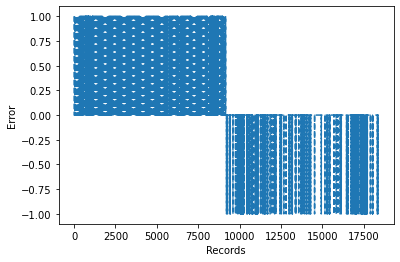

In [7]:
import torch
from model_my import myNet

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

import numpy as np
test_set = hDataset(k, test_data, test_lab)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

_exp_name="HM_hrun4_adappla_3132p5152p_sample"
model_best =myNet(num_classes=output_dim, aux_logits=False, init_weights=False).to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"),strict=False)
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

accuracy=1 - np.count_nonzero(np.array(prediction)-np.array(test_lab))/len(prediction)

print(accuracy)

error=np.array(prediction)-np.array(test_lab)
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(error, linestyle="--")
# plt.legend(loc="best")
plt.xlabel('Records')
plt.ylabel('Error')
plt.show

In [8]:
aerror=np.count_nonzero(np.array(prediction)-np.array(test_lab))/len(prediction)
print(aerror)
accuracy=1 - aerror
print(accuracy)
# import csv
# with open('error.txt','w') as cfile:
#     w = csv.writer(cfile)
#     w.writerow(error)

0.02529923830250272
0.9747007616974973
